# SNN on ISING-MODEL

In this notebook I train a Spiking Neural network on the Ising-model


[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/{user_name}/{repo_name}/blob/{branch_name}/mnist.ipynb)

Clone git repository for execution on google colab

!git clone git@github.com:CSteennis/BscThesis.git

%pip install snntorch
%pip install torchmetrics
%pip install shapely


### Imports

In [16]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
import snntorch.functional as sf
import torch, torch.nn as nn
from torch.utils.data import DataLoader
import numpy as np

from Networks import Networks
from ising import ISING

from plotting import *

from tqdm import tqdm

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Import data to dataloaders

In [14]:
def import_data(L, Ts, train_Ts, avg=False, from_cache=True):
    '''Import data into `DataLoader` objects'''

    train = ISING(L, train=True, Ts=Ts, train_Ts=train_Ts, avg=avg, cache=from_cache)
    test = ISING(L, train=False, Ts=Ts, train_Ts=train_Ts)

    train_loader = DataLoader(train, batch_size=128, shuffle=True)
    test_loader = DataLoader(test, batch_size=64, shuffle=True)

    all_data = train.get_all_data()

    return train_loader, test_loader, all_data

# size of the images
img_size = 10

# The temperatures that we are going to generate samples at
Ts = np.arange(1.95, 0.04, -0.1) * 2.27

train_Ts = list(Ts[:4]) + list(Ts[-4:])

# import training and test data
train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts, avg=True)



#### Plot loaded images

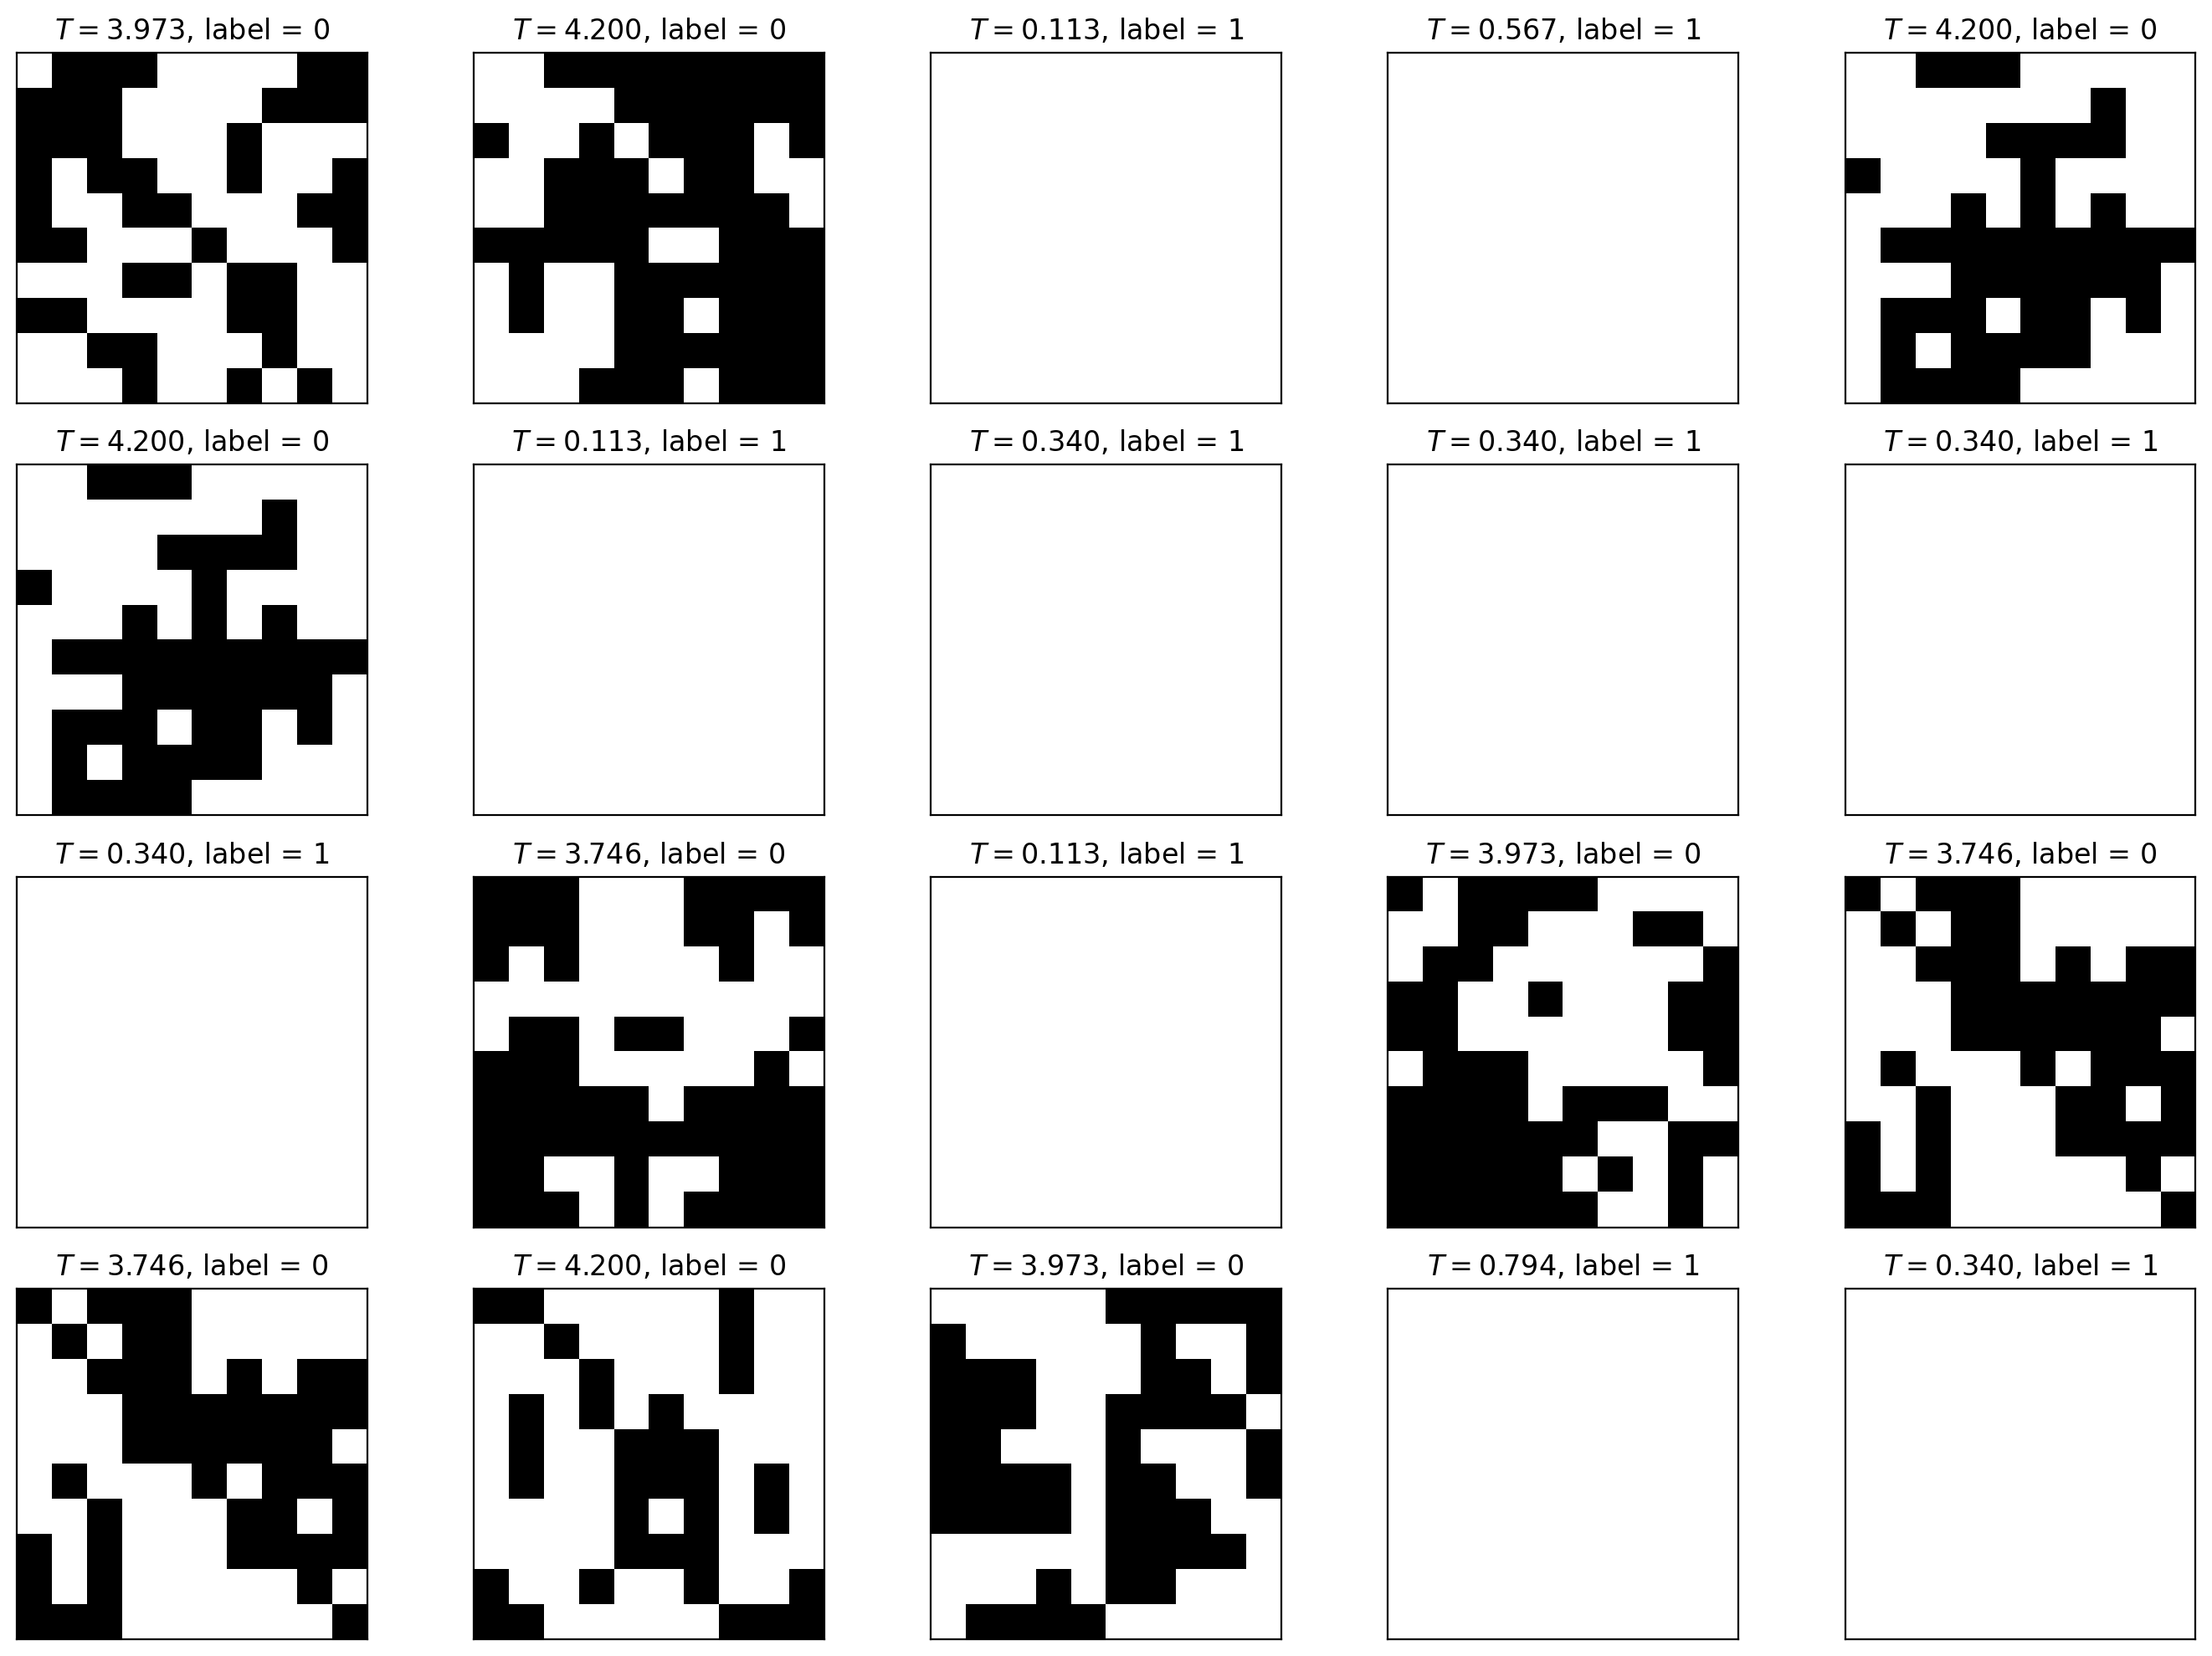

In [15]:

train_T, train_x, train_y = next(iter(test_loader))

fig, ax = plt.subplots(4,5, figsize=(14,10), dpi=200)
for i in range(4):
    for j in range(5):
        ca = ax[i,j].matshow(np.reshape(train_x[(4*i + j)], (img_size,img_size)), cmap='Greys')
        ax[i,j].set_title("$T = %.3f$, label = %d"%(train_T[(4*i + j)], train_y[4*i+j]))
        ax[i,j].set_xticks([])
        ax[i,j].set_yticks([])
        # fig.colorbar(ca)
fig.tight_layout()

fig.savefig("images/Ising-Samples-avg.svg", format='svg')

### Hyper parameters
Hyper parameters for the Neural networks

In [18]:

# number of epochs
epochs = 20

# neuron counts
inputs = img_size * img_size
hiddens = 200
outputs = 2

# membrane potential decay
decay = 0.9

# number of time steps
n_steps = 25 #ms


In [6]:

train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts)

nets = Networks(epochs,inputs,hiddens,outputs,decay,n_steps)

(test_acc_snn_rate, test_loss_snn_rate, _), rate_snn = nets.train_rate_snn(train_loader,test_loader)
(test_acc_snn_temp, test_loss_snn_temp, _), temp_snn = nets.train_temp_snn(train_loader,test_loader)
(test_acc_ffn, test_loss_ffn, _), ffn = nets.train_ffn(train_loader,test_loader)

# (test_acc_csnn_rate, test_loss_csnn_rate, _), rate_csnn = nets.train_conv_rate_snn(train_loader,test_loader)
# (test_acc_csnn_temp, test_loss_csnn_temp, _), temp_csnn = nets.train_conv_temp_snn(train_loader,test_loader)
# (test_acc_conv, test_loss_conv, _), conv = nets.train_cnn(train_loader,test_loader)




KeyboardInterrupt: 

### Test on single img

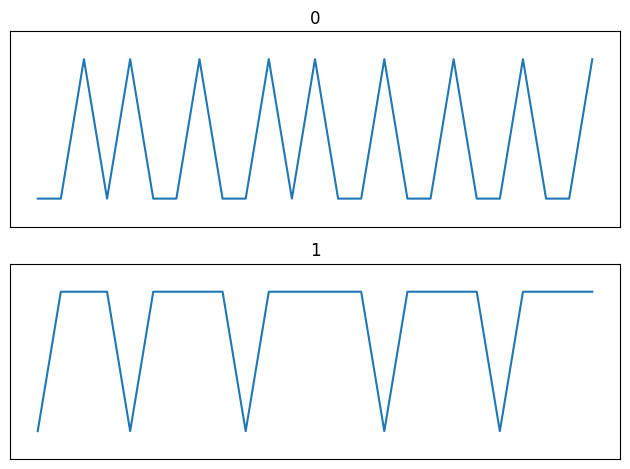

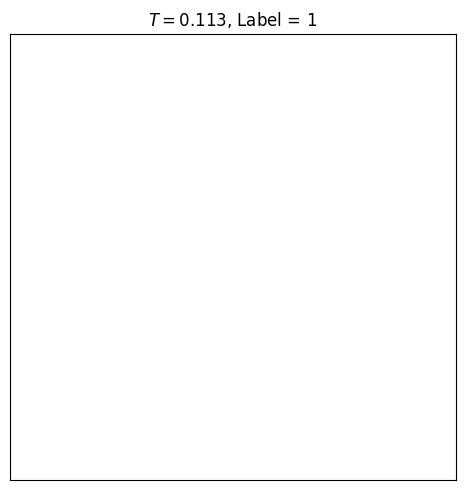

In [ ]:
train_T, train_x, train_y = next(iter(train_loader))
img = train_x[0]
output = rate_snn(img)

fig, ax = plt.subplots(2)

for i in range(2):
    ax[i].plot(output[:,i].detach().numpy())
    ax[i].set_title(f'{i}')
    ax[i].set_ybound(-0.2,1.2)
    ax[i].set_xticks([])
    ax[i].set_yticks([])

fig.tight_layout()

fig, ax = plt.subplots(1, figsize=(7,5))
ax.matshow(np.reshape(img, (img_size,img_size)), cmap='Greys')
ax.set_title("$T = %.3f$, Label = %d"%(train_T[0],train_y[0]))
ax.set_xticks([])
ax.set_yticks([])
fig.tight_layout()


### Comparison

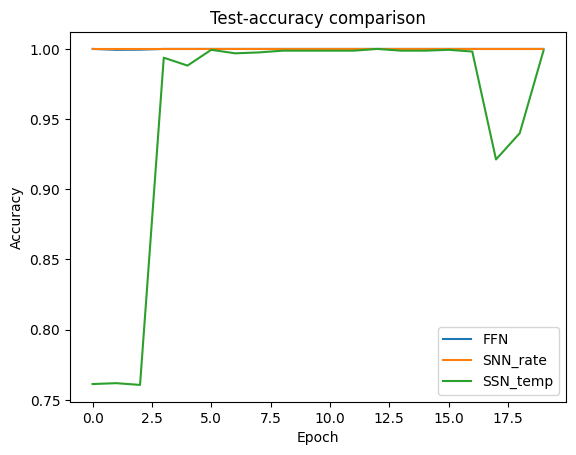

In [ ]:
plot_comparison(FFN=test_acc_ffn, SNN_rate=test_acc_snn_rate, SSN_temp=test_acc_snn_temp)


### Finite size scaling

In [13]:
def normalize(x):
    return (x-np.nanmin(x, axis=0))/(np.max(x, axis=0)-np.nanmin(x, axis=0))

In [8]:

import json
from Ising.IsingData import generate_Ising_configurations

# For a few different system sizes, store the data in a dictionary with L as key
def generate_Ising_data(L, numSamplesPerT, Ts) -> dict:
    try:
        with open(f'cache/{L}-{numSamplesPerT}.json', 'r') as file:
            all_data = {key: np.array(val) for key, val in json.load(file).items()}
    except:
        all_data = generate_Ising_configurations(L, numSamplesPerT, Ts)
        with open(f'cache/{L}-{numSamplesPerT}.json', 'w') as file:
            json.dump({key: val.tolist() for key, val in all_data.items()}, file)
    return all_data



10
20
40
80
160


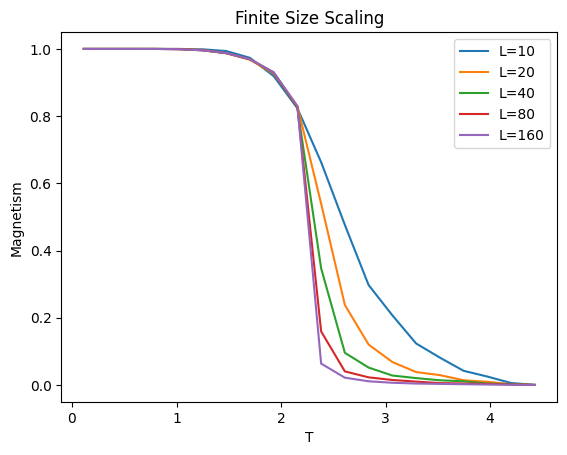

In [80]:
L_list = [10, 20, 40, 80, 160]
fig, ax = plt.subplots()
for L in L_list:
    print(L)
    all_data = ISING(L,0,Ts,Ts).get_all_data()
    # print (all_data)
    m_square = []
    for T, imgs in all_data.items():
        m_T = []
        for img in imgs:
            m_T.append(np.sqrt(np.square(np.sum(img))))
        m_square.append(np.mean(m_T))

    y = normalize(m_square)

    ax.plot(Ts, y, label=f'L={L}')
ax.legend()
ax.set_title('Finite Size Scaling')
ax.set_xlabel('T')
ax.set_ylabel('Magnetism')
fig.savefig("images/FiniteSizeScaling_ISING.svg", format='svg')


### Blanking

#### Predict in between values

In [9]:

def predict_spiking(net, all_data, Ts):
    predictions = []
    with torch.no_grad():
        for T in Ts:
            # get all imgs for temp T
            x = torch.from_numpy(np.clip(all_data['%.3f'%T].astype('float32'),0,1))#['x']
            # predict
            p = net(x)
            # sum spikes over time
            p : torch.Tensor = p.sum(dim=0)
            p = p.div(p.sum(dim=1, keepdim=True))
            p[p != p] = 0
            p = p.nanmean(dim=0).detach().numpy()
            predictions.append(p)
        x = np.array(predictions)
        return normalize(x)

def predict(net, all_data, Ts):
    predictions = []
    with torch.no_grad():
        for T in Ts:
            # get all imgs for temp T
            x = torch.from_numpy(np.clip(all_data['%.3f'%T].astype('float32'),0,1))#['x']
            # predict
            p = net(x)
            p = p.nanmean(dim=0).detach().numpy()
            predictions.append(p)
        x = np.array(predictions)
        return normalize(x)


#### Plot predictions

In [10]:
from scipy.optimize import curve_fit
from shapely.geometry import LineString, MultiPoint

def sigmoid(x, L ,x0, k, b):
    y = L / (1 + np.exp(-k*(x-x0))) + b
    return (y)

def extract_Tc(p):
    lines : list[LineString] = []

    for i in range(p.shape[1]):
        # guess x0
        p0 = [np.nanmax(p[:,i]), np.median(Ts),1,np.nanmin(p[:,i])]

        # fit the curve
        try:
            popt, _ = curve_fit(sigmoid, Ts, p[:,i], p0, method='dogbox')
            y = sigmoid(Ts, *popt)
            lines.append(LineString(np.column_stack((Ts, y))))
        except:
            lines.append(LineString(np.column_stack((Ts, p[:,i]))))
        
        

    # intersect
    try:
        return lines[0].intersection(lines[1]).x
    except:
        try:
            intersectx = 0
            diff = 1
            for (x,y) in zip(lines[0].intersection(lines[1]).coords.xy[0], lines[0].intersection(lines[1]).coords.xy[1]):
                if y - 0.5 < diff:
                    diff = y - 0.5
                    intersectx = x
            return intersectx
        except:
            intersectx = 0
            diff = 1
            intersec : MultiPoint = lines[0].intersection(lines[1])
            for geom in intersec.geoms:
                for (x,y) in zip(geom.coords.xy[0], geom.coords.xy[1]):
                    if y - 0.5 < diff:
                        diff = y - 0.5
                        intersectx = x
            return intersectx



In [22]:
img_size = 20

train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts, from_cache=True)


In [23]:

nets = Networks(20, img_size*img_size, hiddens, outputs, decay, 200)

_, ffn = nets.train_ffn(train_loader, test_loader)
_, rsnn = nets.train_rate_snn(train_loader, test_loader)
_, lsnn = nets.train_temp_snn(train_loader, test_loader)

predictions = [predict(ffn, all_data, Ts), predict_spiking(rsnn, all_data, Ts), predict_spiking(lsnn, all_data, Ts)]

plot_predictions(Ts, FFN={'val': predictions[0], 'color': 'r'}, 
                     Rate_coded={'val': predictions[1], 'color': 'g'},
                     Latency_coded={'val': predictions[2], 'color': 'b'})

print([extract_Tc(p) for p in predictions])

KeyboardInterrupt: 

#### Best input size

  0%|          | 0/3 [00:00<?, ?it/s]

handling  10
Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113
training...
predicting...
handling  20
Generating samples for L = 20 at T = 4.426
Generating samples for L = 20 at T = 4.199
Ge

 33%|███▎      | 1/3 [1:02:34<2:05:08, 3754.10s/it]

handling  10
Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113
training...
predicting...
handling  20
Generating samples for L = 20 at T = 4.426
Generating samples for L = 20 at T = 4.199
Ge

 67%|██████▋   | 2/3 [1:29:04<41:21, 2481.47s/it]  

handling  10
Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113
training...
predicting...
handling  20
Generating samples for L = 20 at T = 4.426
Generating samples for L = 20 at T = 4.199
Ge

100%|██████████| 3/3 [3:08:46<00:00, 3775.48s/it]


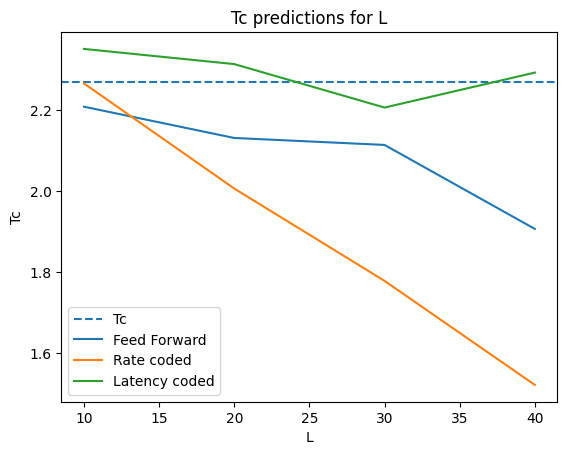

In [19]:

Tc = 2.2692


L_list = [10, 20, 30, 40]#, 80, 160]



ffn_tot = []
rsnn_tot = []
lsnn_tot = []

repeats = 3
for r in tqdm(range(repeats)):
    Tc_L_rate_list = []
    Tc_L_temp_list = []
    Tc_L_ffn_list = []

    for L in L_list:
        print('handling ', L)
        inputs = L*L
        train_loader, test_loader, all_data = import_data(L, Ts, train_Ts, avg=True, from_cache=False)

        # initiate networks
        nets = Networks(epochs,inputs,hiddens,outputs,decay,n_steps)

        # train networks
        print('training...')
        _, ffn = nets.train_ffn(train_loader, test_loader)
        (test_acc_snn_temp, test_loss_snn_temp, _), temp_snn = nets.train_temp_snn(train_loader,test_loader)
        (test_acc_snn_rate, test_loss_snn_rate, _), rate_snn = nets.train_rate_snn(train_loader,test_loader)

        # predict
        print('predicting...')
        predictions_ffn = predict(ffn, all_data, Ts)
        predictions_rate = predict_spiking(rate_snn, all_data, Ts)
        predictions_temp = predict_spiking(temp_snn, all_data, Ts)

        Tc_ffn = extract_Tc(predictions_ffn)
        Tc_rate = extract_Tc(predictions_rate)
        Tc_temp = extract_Tc(predictions_temp)

        Tc_L_ffn_list.append(Tc_ffn)
        Tc_L_rate_list.append(Tc_rate)
        Tc_L_temp_list.append(Tc_temp)

    ffn_tot.append(Tc_L_ffn_list)
    rsnn_tot.append(Tc_L_rate_list)
    lsnn_tot.append(Tc_L_temp_list)


fig, ax = plt.subplots()

ax.axhline(Tc, linestyle='--', label='Tc')

ax.plot(L_list, np.mean(ffn_tot, axis=0), label='Feed Forward')
ax.plot(L_list, np.mean(rsnn_tot, axis=0), label='Rate coded')
ax.plot(L_list, np.mean(lsnn_tot, axis=0), label='Latency coded')
ax.legend()
ax.set_title('Tc predictions for L')
ax.set_xlabel('L')
ax.set_ylabel('Tc')
fig.savefig('images/Tc_predictions_L.svg', format='svg')


In [1]:
plot_predicted_Tc(L_list, Tc_L_rate_list, Tc_L_temp_list, 'L')

# fig, ax = plt.subplots()
# ax.set_title("Tc prediction per L")
# ax.set_xlabel("L")
# ax.set_ylabel("Predicted Tc")
# ax.plot(L_list, Tc_L_rate_list, label="Rate coded")
# ax.plot(L_list, Tc_L_temp_list, label="Latency coded")
# ax.axhline(Tc, color='r', linestyle='--', label='Tc')
# ax.legend()
# fig.savefig("images/Tc_predictions_L.svg", format='svg')

NameError: name 'plot_predicted_Tc' is not defined

#### Best number of time steps


In [24]:

step_list = [15, 25, 50, 75, 100, 150, 200]

rsnn_tot = []
lsnn_tot = []

img_size = 10
inputs = img_size*img_size

repeats = 5
for r in range(repeats):
    Tc_steps_rate_list = []
    Tc_steps_temp_list = []

    train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts, avg=True, from_cache=False)

    for step in step_list:
        print('handling ', step)
        # initiate networks
        nets = Networks(epochs,inputs,hiddens,outputs,decay,step)

        # train networks
        print('training...')
        (test_acc_snn_temp, test_loss_snn_temp, _), temp_snn = nets.train_temp_snn(train_loader,test_loader)
        (test_acc_snn_rate, test_loss_snn_rate, _), rate_snn = nets.train_rate_snn(train_loader,test_loader)

        # predict
        print('predicting...')
        predictions_rate = predict_spiking(rate_snn, all_data, Ts)
        predictions_temp = predict_spiking(temp_snn, all_data, Ts)

        Tc_rate = extract_Tc(predictions_rate)
        Tc_temp = extract_Tc(predictions_temp)

        Tc_steps_rate_list.append(Tc_rate)
        Tc_steps_temp_list.append(Tc_temp)
        
        # Tc_rate_error_avg.append(abs(1-(Tc_rate/Tc)))
        # Tc_temp_error_avg.append(abs(1-(Tc_temp/Tc)))

    rsnn_tot.append(Tc_steps_rate_list)
    lsnn_tot.append(Tc_steps_temp_list)

fig, ax = plt.subplots()

ax.axhline(Tc, linestyle='--', label='Tc')

ax.plot(L_list, np.mean(rsnn_tot, axis=0), label='Rate coded')
ax.plot(L_list, np.mean(lsnn_tot, axis=0), label='Latency coded')
ax.legend()
ax.set_title('Tc predictions for steps')
ax.set_xlabel('n_steps')
ax.set_ylabel('Tc')
fig.savefig('images/Tc_predictions_n_steps.svg', format='svg')

Generating samples for L = 10 at T = 4.426
Generating samples for L = 10 at T = 4.199
Generating samples for L = 10 at T = 3.972
Generating samples for L = 10 at T = 3.745
Generating samples for L = 10 at T = 3.518
Generating samples for L = 10 at T = 3.291
Generating samples for L = 10 at T = 3.064
Generating samples for L = 10 at T = 2.837
Generating samples for L = 10 at T = 2.610
Generating samples for L = 10 at T = 2.383
Generating samples for L = 10 at T = 2.156
Generating samples for L = 10 at T = 1.929
Generating samples for L = 10 at T = 1.702
Generating samples for L = 10 at T = 1.475
Generating samples for L = 10 at T = 1.248
Generating samples for L = 10 at T = 1.021
Generating samples for L = 10 at T = 0.794
Generating samples for L = 10 at T = 0.567
Generating samples for L = 10 at T = 0.340
Generating samples for L = 10 at T = 0.113
handling  15
training...


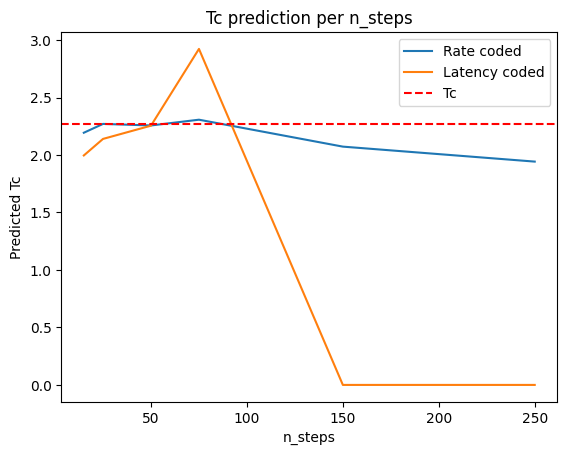

In [120]:

plot_predicted_Tc(step_list, Tc_steps_rate_list, Tc_steps_temp_list, 'n_steps')

# fig, ax = plt.subplots()
# ax.plot(step_list, Tc_steps_rate_list, label='Rate coded')
# ax.plot(step_list, Tc_steps_temp_list, label='Latency coded')

# ax.legend()
# fig.show()

results with avg


 30%|███       | 3/10 [05:22<12:34, 107.83s/it]

[1.0, 2.269999999999998, 1, 0.0]


100%|██████████| 10/10 [17:57<00:00, 107.76s/it]


avg results
Rate_SNN: 	 2.257905473640059 	error: 	 0.012235487550042511
Temp_SNN: 	 2.28947366362362 	error: 	 0.0548830027536775
FFN:      	 2.2248876184458064 	error: 	 0.019441331667780427
results without avg


100%|██████████| 10/10 [17:57<00:00, 107.73s/it]

avg results
Rate_SNN: 	 2.2803054719397147 	error: 	 0.012094588027944808
Temp_SNN: 	 2.2004525185770576 	error: 	 0.058917664210637696
FFN:      	 2.2067728046595803 	error: 	 0.027502091213751134


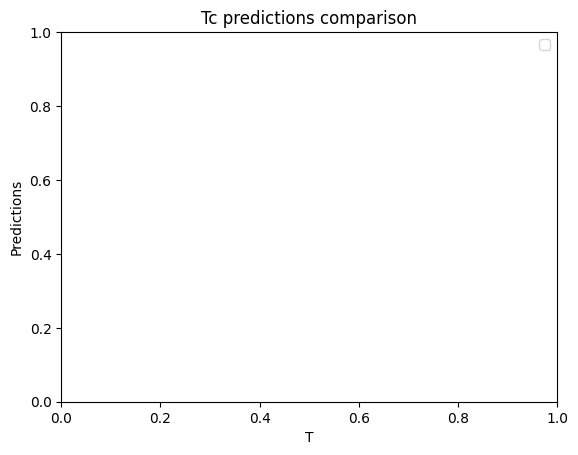

In [ ]:
from tqdm import tqdm

repeats = 10

print("results with avg")

# import data

inputs = img_size*img_size

Tc_rate_avg = []
Tc_rate_error_avg = []

Tc_temp_avg = []
Tc_temp_error_avg = []

Tc_ffn_avg = []
Tc_ffn_error_avg = []


for i in tqdm(range(repeats)):
    train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts, avg=True, from_cache=False)
    # train nets
    nets = Networks(epochs,inputs,hiddens,outputs,decay,n_steps)

    (test_acc_snn_rate, test_loss_snn_rate, _), rate_snn = nets.train_rate_snn(train_loader,test_loader)
    (test_acc_snn_temp, test_loss_snn_temp, _), temp_snn = nets.train_temp_snn(train_loader,test_loader)
    (test_acc_ffn, test_loss_ffn, _), ffn = nets.train_ffn(train_loader,test_loader)

    # predict
    predictions_rate = predict_spiking(rate_snn, all_data, Ts)
    predictions_temp = predict_spiking(temp_snn, all_data, Ts)
    predictions_ffn = predict(ffn, all_data, Ts)

    Tc_rate = extract_Tc(predictions_rate)
    Tc_temp = extract_Tc(predictions_temp)
    Tc_ffn = extract_Tc(predictions_ffn)

    Tc_rate_avg.append(Tc_rate)
    Tc_temp_avg.append(Tc_temp)
    Tc_ffn_avg.append(Tc_ffn)

    Tc = 2.2692

    Tc_rate_error_avg.append(abs(1-(Tc_rate/Tc)))
    Tc_temp_error_avg.append(abs(1-(Tc_temp/Tc)))
    Tc_ffn_error_avg.append(abs(1-(Tc_ffn/Tc)))


print("avg results")
print("Rate_SNN: \t", (np.array(Tc_rate_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_rate_error_avg).sum()/repeats))
print("Temp_SNN: \t", (np.array(Tc_temp_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_temp_error_avg).sum()/repeats))
print("FFN:      \t", (np.array(Tc_ffn_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_ffn_error_avg).sum()/repeats))

print("results without avg")

# import data

Tc_rate_avg = []
Tc_rate_error_avg = []

Tc_temp_avg = []
Tc_temp_error_avg = []

Tc_ffn_avg = []
Tc_ffn_error_avg = []

for i in tqdm(range(repeats)):
    train_loader, test_loader, all_data = import_data(img_size, Ts, train_Ts, avg=False, from_cache=False)
    # train nets
    nets = Networks(epochs,inputs,hiddens,outputs,decay,n_steps)

    (test_acc_snn_rate, test_loss_snn_rate, _), rate_snn = nets.train_rate_snn(train_loader,test_loader)
    (test_acc_snn_temp, test_loss_snn_temp, _), temp_snn = nets.train_temp_snn(train_loader,test_loader)
    (test_acc_ffn, test_loss_ffn, _), ffn = nets.train_ffn(train_loader,test_loader)

    # predict
    predictions_rate = predict_spiking(rate_snn, all_data, Ts)
    predictions_temp = predict_spiking(temp_snn, all_data, Ts)
    predictions_ffn = predict(ffn, all_data, Ts)

    Tc_rate = extract_Tc(predictions_rate)
    Tc_temp = extract_Tc(predictions_temp)
    Tc_ffn = extract_Tc(predictions_ffn)

    Tc_rate_avg.append(Tc_rate)
    Tc_temp_avg.append(Tc_temp)
    Tc_ffn_avg.append(Tc_ffn)

    Tc = 2.2692

    Tc_rate_error_avg.append(abs(1-(Tc_rate/Tc)))
    Tc_temp_error_avg.append(abs(1-(Tc_temp/Tc)))
    Tc_ffn_error_avg.append(abs(1-(Tc_ffn/Tc)))

print("avg results")

print("Rate_SNN: \t", (np.array(Tc_rate_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_rate_error_avg).sum()/repeats))
print("Temp_SNN: \t", (np.array(Tc_temp_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_temp_error_avg).sum()/repeats))
print("FFN:      \t", (np.array(Tc_ffn_avg).sum()/repeats), "\terror: \t" , (np.array(Tc_ffn_error_avg).sum()/repeats))
